In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
import glob

In [2]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
classes = ['down', 'none', 'up']
classes

['down', 'none', 'up']

In [4]:
model_labeling = nn.Sequential(*[
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1, stride = 1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1, stride = 2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1, stride = 2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1, stride = 2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7168, 3)
])
model_labeling.load_state_dict(torch.load("ModeloCustomEtiquetadoBotones_BIEN.pth"))
model_labeling.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=7168, out_features=3, bias=True)
)

In [5]:
class VideoFrames(torch.utils.data.Dataset):
    """
    Dataset que carga un vídeo y extrae los frames
    """
    def __init__(self, path, transform = None):
        """
        path --> Path del que cargar el vídeo
        """
        super(VideoFrames, self).__init__()
        
        self.path = path
        # self.images_path = glob.glob(f"{path}/*.jpg")  
        self.frames = self.extract_frames(self.path)
        # self.images = np.array([np.array(Image.open(image)) for image in self.images_path])
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        images = self.frames[idx]
        if self.transform:
            images = self.transform(images)
        return images

    def extract_frames(self, path_to_video):    
        """Coge un vídeo y extrae todos sus frames"""
        frames = []
        vidcap = cv2.VideoCapture(path_to_video)
        success,image = vidcap.read()
        count = 0
        while success:
            #Detallito porque OpenCV las carga como BGR y las queremos en RGB por consistencia
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            frames.append(image)
            success,image = vidcap.read()
            count += 1
        print(f"Extracted {count} frames!")
        return np.array(frames)

In [6]:
def label(model, imageloader):
    """
    Usamos el modelo dado para etiquetar las imágenes. 
    Hay que pasarlas como un dataloder directamente.
    Devuelve una lista con las etiquetas correspondientes

    Args:
    model -> Modelo de Pytorch
    imageloader -> DataLoader con las imágenes que queremos etiquetar

    Return:
    Devuelve una lista con las etiquetas correspondientes
    """
    labels = np.array([])
    for X in imageloader:
        X = X.to(device)
        with torch.no_grad():
            #Sacamos la predicción
            pred = model(X)
        #A la predicción hay que hacerle la SoftMax para sacar la etiqueta
        labels_batch = torch.softmax(pred, axis = 1).argmax(axis = 1)
        labels = np.concatenate((labels,labels_batch.cpu().numpy()), axis = 0)
        labels_name = [classes[int(label)] for label in labels]
    return labels_name

In [7]:
mask = cv2.imread("Crops/Mask_Right_Bot.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = torch.Tensor(mask)
mask = mask / mask.max()

In [8]:
lambda_crop = torchvision.transforms.Lambda(lambda x: x[:,420:,183:235])
lambda_mask = torchvision.transforms.Lambda(lambda x: x * mask)

In [9]:
transform_label = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda_crop,
    lambda_mask,
])

In [10]:
lambda_crop_game = torchvision.transforms.Lambda(lambda x: x[:,15:-20,265:])

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda_crop_game,
    torchvision.transforms.Resize(224)
])

In [13]:
class VideoFramesTemporal(torch.utils.data.Dataset):
    """
    La idea es que este dataset nos devuelva directamente las cosas en el formato apropiado para
    poder usar el modelo con la LSTM. 
    """
    def __init__(self, path, model_labeling, lag = 3, transform_label = None, transform = None):
        """
        Argumentos:
        path -> Path del que cargar el vídeo
        model_labeling -> Modelo utilizado para etiquetar los frames
        transform_label -> Transformaciones utilizadas para etiquetar los frames
        transform -> Transformaciones utilizadas sobre las imágenes finales
        """
        super(VideoFramesTemporal, self).__init__()
        
        self.path = path

        self.frames = self.extract_frames(self.path)
        self.labels = self.get_labels(model_labeling, transform_label)
        
        self.lag = lag
        self.transform = transform
        self.transform_label = transform_label

        self.data, self.temporal_labels = self.create_temporal_dataset_2()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.temporal_labels[idx]
        # if self.transform:
        #     data = self.transform(data)
        return data, label

    def extract_frames(self, path_to_video):    
        """Coge un vídeo y extrae todos sus frames"""
        frames = []
        vidcap = cv2.VideoCapture(path_to_video)
        success,image = vidcap.read()
        count = 0
        while success:
            #Detallito porque OpenCV las carga como BGR y las queremos en RGB por consistencia
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            frames.append(image)
            success,image = vidcap.read()
            count += 1
        print(f"Extracted {count} frames!")
        return np.array(frames)
    
    def get_labels(self, model_labeler, transform_label):
        labels = np.array([])
        # transform_label = self.transform_label
        temp_dataloader_labeling = torch.utils.data.DataLoader(VideoFrames(self.path, transform = transform_label), batch_size = 16)

        for X in temp_dataloader_labeling:
            # X = X.to(device)

            with torch.no_grad():
                #Sacamos la predicción
                pred = model_labeler(X)

            #A la predicción hay que hacerle la SoftMax para sacar la etiqueta
            labels_batch = torch.softmax(pred, axis = 1).argmax(axis = 1)
            labels = np.concatenate((labels,labels_batch.cpu().numpy()), axis = 0)
            labels_name = [classes[int(label)] for label in labels]
        
        return labels

    def create_temporal_dataset(self):
        """
        Cogemos un dataset de frames secuenciales, sus etiquetas asociadas y el lag que queremos utilizar.
        Devolvemos el dataset de forma que cada ejemplo sean tres frames consecutivos y la etiqueta, la que
        corresponde al siguiente frame.

        Argumentos:
        frames_dataset_list -> Dataset de PyTorch convertido a lista mediante list(dataset)
        labels -> Lista con las etiquetas que corresponde a cada imagen
        lag -> Cantidad de frames que queremos utilizar para cada prediccion

        Return:
        dataset -> Dataset formateado según (Ejemplos, Frames por ejemplo, Canales, Alto, Ancho)
        labels_dataset -> Etiquetas asociadas al dataset
        """
        frames_dataset = VideoFrames(self.path, transform = self.transform)
        frames_dataset_list = list(frames_dataset)
        labels = self.labels
        lag = self.lag
        labels_dataset = []
        
        for i, (_, __) in enumerate(zip(frames_dataset_list, frames_dataset_list[lag:])):
            # print(i)
            if i == 0:
                dataset = torch.unsqueeze(torch.stack(frames_dataset_list[i:i+lag]),0)

            else:
                dataset = torch.vstack((dataset, torch.unsqueeze(torch.stack(frames_dataset_list[i:i+lag]), 0)))

            labels_dataset.append(labels[i+lag])

        return dataset, labels_dataset

    def create_temporal_dataset_2(self):
        """
        Cogemos un dataset de frames secuenciales, sus etiquetas asociadas y el lag que queremos utilizar.
        Devolvemos el dataset de forma que cada ejemplo sean tres frames consecutivos y la etiqueta, la que
        corresponde al siguiente frame.

        Argumentos:
        frames_dataset_list -> Dataset de PyTorch convertido a lista mediante list(dataset)
        labels -> Lista con las etiquetas que corresponde a cada imagen
        lag -> Cantidad de frames que queremos utilizar para cada prediccion

        Return:
        dataset -> Dataset formateado según (Ejemplos, Frames por ejemplo, Canales, Alto, Ancho)
        labels_dataset -> Etiquetas asociadas al dataset
        """
        frames_dataset = VideoFrames(self.path, transform = self.transform)
        frames_dataset_list = list(frames_dataset)
        labels = self.labels
        lag = self.lag
        labels_dataset = []
        dataset = torch.empty(len(frames_dataset_list)-lag, lag, *frames_dataset_list[0].shape)
        # print(dataset.shape)
        # return
        for i, (_, __) in enumerate(zip(frames_dataset_list, frames_dataset_list[lag:])):
            
            dataset[i] = torch.stack(frames_dataset_list[i:i+lag])

            labels_dataset.append(int(labels[i+lag]))

        return dataset, labels_dataset

In [15]:
dataset_1 = VideoFramesTemporal("Crops/1-1.mp4", model_labeling, 3, transform_label = transform_label, transform = transform)
dataset_2 = VideoFramesTemporal("Crops/1-2.mp4", model_labeling, 3, transform_label = transform_label, transform = transform)
dataset_3 = VideoFramesTemporal("Crops/1-3.mp4", model_labeling, 3, transform_label = transform_label, transform = transform)
dataset_4 = VideoFramesTemporal("Crops/5-22.mp4", model_labeling, 3, transform_label = transform_label, transform = transform)
dataset_5 = VideoFramesTemporal("Crops/BotonRojo.mp4", model_labeling, 3, transform_label = transform_label, transform = transform)

Extracted 869 frames!
Extracted 869 frames!
Extracted 869 frames!
Extracted 604 frames!
Extracted 604 frames!
Extracted 604 frames!


In [33]:
prueba_concats = torch.utils.data.ConcatDataset((dataset_2, dataset_3, dataset_4, dataset_5))

In [34]:
len(dataset), len(dataset_2), len(prueba_concats)

(3999, 935, 3114)

In [35]:
dataset = prueba_concats

In [36]:
train_split = 0.7
train_length = int(len(dataset)*train_split)
test_length = int(len(dataset)) - int(len(dataset)*train_split)

train, test = torch.utils.data.random_split(dataset, [train_length, test_length], generator = torch.Generator().manual_seed(42))
len(train), len(test)

(2179, 935)

In [37]:
BATCH_SIZE = 12
trainloader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
testloader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

# Modelo

In [22]:
def train_fn(model, optimizer, loss_fn, epochs, trainloader, testloader):    
    """
    Bucle de entrenamiento completo.

    Argumentos:
    model -> Modelo a entrenar
    optimizer -> Optimizador a utilizar
    loss_fn -> Función de pérdida a utilizar
    epochs -> Cantidad de épocas de entrenamiento
    trainloader -> Objeto DataLoader de entrenamiento
    testloader -> Objeto DataLoader de test

    Returns:
    losses -> Coste durante el entrenamiento
    accuracies -> Precisión durante el entrenamiento
    losses_test -> Coste durante el test
    accuracies_test -> Precisión durante el test
    """
    EPOCHS = epochs

    losses = []
    losses_test = []
    accuracies = []
    accuracies_test = []

    for epoch in range(EPOCHS):

        loss_epoch = 0
        loss_epoch_test = 0
        accuracy_epoch = []
        accuracy_epoch_test = []

        for X, Y in trainloader:
            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()

            pred = model(X)
            loss = loss_fn(pred, Y)

            loss.backward()
            optimizer.step()

            loss_epoch += loss
            accuracy_epoch.append(accuracy_score(Y, pred).item()) #Con item nos metemos el número sin tensor ni nada
        
        losses.append(loss_epoch)
        accuracies.append(np.mean(accuracy_epoch))
        
        for X_test, Y_test in testloader:
            X_test, Y_test = X_test.to(device), Y_test.to(device)

            with torch.no_grad():
                pred_test = model(X_test)
                loss_test = loss_fn(pred_test, Y_test)

            loss_epoch_test += loss_test
            accuracy_epoch_test.append(accuracy_score(Y_test, pred_test).item())

        losses_test.append(loss_epoch_test)
        accuracies_test.append(np.mean(accuracy_epoch_test))

        print(f"Época {epoch+1} --> Train: (BCE) {losses[-1]:.5f} (Accuracy): {accuracies[-1]:.5f} | Test: (BCE) {losses_test[-1]:.5f} (Accuracy): {accuracies_test[-1]:.5f}")
    return losses, accuracies, losses_test, accuracies_test

In [23]:
class TemporalModel(nn.Module):
    def __init__(self):
        super(TemporalModel, self).__init__()
        self.convolutions = nn.Sequential(*[
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(4),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Linear(64*14*18, 100),
        nn.ReLU(),
    ])
        self.hidden_size = 50
        self.lstm = nn.LSTM(input_size = 100, hidden_size = self.hidden_size, num_layers = 1, batch_first = True, dropout=0.5)
        #Definimos el estado oculto
        self.hidden_cell = (torch.zeros(1,12,self.hidden_size).to(device),
                            torch.zeros(1,12,self.hidden_size).to(device))
        
        self.final_linear = nn.Linear(self.hidden_size, 3)

    def forward(self, x):      
        pred = torch.empty(x.shape[0],3,100).to(device)

        for i in range(x.shape[1]):
            pred[:,i,:] = self.convolutions(x[:,i,:,:,:])

        pred, self.hidden_cell = self.lstm(pred, self.hidden_cell)


        #Tenemos que hacerle detach al hidden_cell porque eso no se ajusta
        self.hidden_cell = tuple(a.detach() for a in self.hidden_cell)

        # Nos quedamos solamente con el elemento que corresponde al último
        # instante temporal
        pred = self.final_linear(pred[:,-1,:])

        return pred

In [25]:
def accuracy_score(y_true, y_pred):
    y_pred = torch.softmax(y_pred, axis = 1).argmax(axis = 1)
    return torch.where(y_true == y_pred, 1, 0).sum() / len(y_pred)

In [51]:
model_temporal = TemporalModel()
model_temporal.to(device)
optimizer = torch.optim.Adam(model_temporal.parameters())
loss_fn = nn.CrossEntropyLoss()

In [52]:
a, b, c, d = train_fn(model_temporal, optimizer, loss_fn, 25, trainloader, testloader)

Época 1 --> Train: (BCE) 140.03105 (Accuracy): 0.59945 | Test: (BCE) 53.79993 (Accuracy): 0.60931
Época 2 --> Train: (BCE) 124.91840 (Accuracy): 0.66344 | Test: (BCE) 44.26486 (Accuracy): 0.79004
Época 3 --> Train: (BCE) 98.24722 (Accuracy): 0.79236 | Test: (BCE) 39.40427 (Accuracy): 0.80303
Época 4 --> Train: (BCE) 89.85541 (Accuracy): 0.80617 | Test: (BCE) 37.30617 (Accuracy): 0.81602
Época 5 --> Train: (BCE) 86.24546 (Accuracy): 0.80985 | Test: (BCE) 35.83331 (Accuracy): 0.82143
Época 6 --> Train: (BCE) 87.83156 (Accuracy): 0.80755 | Test: (BCE) 37.79688 (Accuracy): 0.80952
Época 7 --> Train: (BCE) 81.93139 (Accuracy): 0.81031 | Test: (BCE) 35.64917 (Accuracy): 0.80628
Época 8 --> Train: (BCE) 77.27853 (Accuracy): 0.82320 | Test: (BCE) 33.99969 (Accuracy): 0.81602
Época 9 --> Train: (BCE) 73.40175 (Accuracy): 0.83241 | Test: (BCE) 32.48549 (Accuracy): 0.83766
Época 10 --> Train: (BCE) 67.77424 (Accuracy): 0.85267 | Test: (BCE) 31.85879 (Accuracy): 0.82900
Época 11 --> Train: (BCE) 6

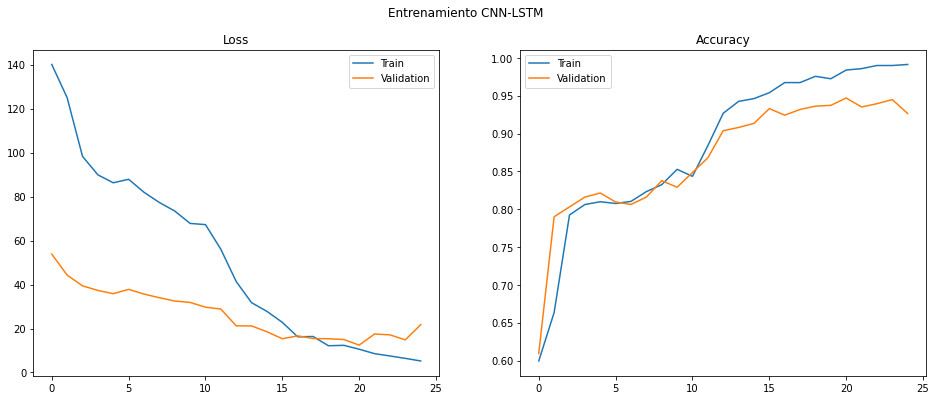

In [55]:
plt.figure(figsize = (16,6))
plt.suptitle("Entrenamiento CNN-LSTM")
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(a, label = "Train")
plt.plot(c, label = "Validation")
plt.legend()
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(b, label = "Train")
plt.plot(d, label = "Validation")
plt.legend()
plt.savefig("Presentacion/Trainings/EntrenamientoCNN-LSTM_No11.png")
plt.show()

In [56]:
torch.save(model_temporal.state_dict(), "ModeloLSTM_NO11_12_13_522_BotonRojo.pth")